# Creating Container for Simulated Data
In this notebook, I want to derive a HDF5 container for a given simulated network (simulated by `NetSim`). For that, I have to create simulated feature vectors and a training and test split.

In [67]:
import pandas as pd
import networkx as nx
import numpy as np
import h5py
np.set_printoptions(precision=1, suppress=True)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [111]:
# params
test_ratio = .3
pos_distr = (50, 60) # mean and variance
neg_distr = (20, 60) # mean and variance
num_features = 20

## Load Network and Insert Positions from Disk

In [112]:
# read the network and insert positions
network = nx.read_edgelist('../data/simulation/network.edgelist')
insert_positions = []
with open('../data/simulation/implant_positions.txt', 'r') as f:
    for line in f.readlines():
        if line.startswith('#'): # comment
            pass
        elif line.startswith('Subnetwork'):
            positions = line.split(':')[1].strip().split('\t')
            insert_positions.append([int(i) for i in positions])
print (network.number_of_nodes(), network.number_of_edges())

1053 2275


## Assign Feature Vector

In [113]:
num_nodes = network.number_of_nodes()
all_clique_nodes = np.array(insert_positions).reshape(-1)
features = np.random.normal(loc=neg_distr[0], scale=np.sqrt(neg_distr[1]),
                            size=(num_nodes, num_features))
features[all_clique_nodes] = np.random.normal(loc=pos_distr[0], scale=np.sqrt(pos_distr[1]),
                                              size=(all_clique_nodes.shape[0], num_features))
not_clique_mems = np.array([i for i in np.arange(num_nodes) if not i in all_clique_nodes])
features[features < 0] = 0 # no negative gene expression

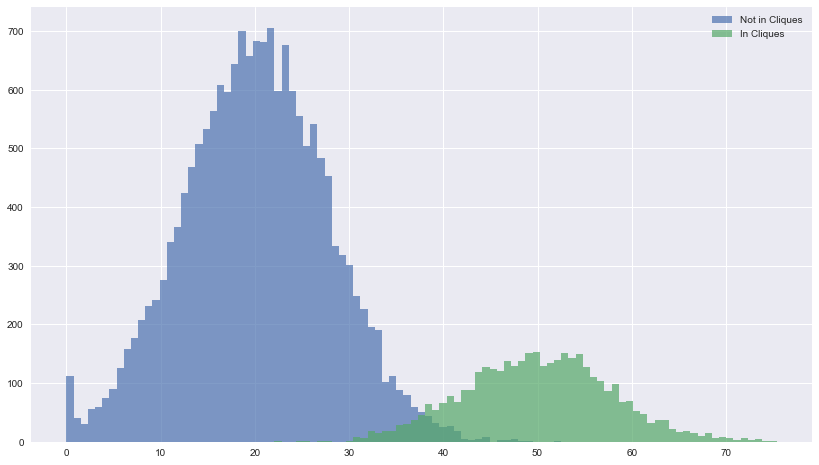

In [114]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(features.min(), features.max(), 100)
_ = plt.hist(features[not_clique_mems].reshape(-1), bins=bins, label='Not in Cliques', normed=False, alpha=.7)
_ = plt.hist(features[all_clique_nodes].reshape(-1), bins=bins, label='In Cliques', normed=False, alpha=.7)
_ = plt.legend()

## Compute Split

In [115]:
y = np.array([1 if i in all_clique_nodes else 0 for i in np.arange(num_nodes)])
print (y.shape, y.sum())
train_nodes, test_nodes = train_test_split(np.arange(num_nodes), test_size=test_ratio, stratify=y)

(1053,) 190


In [116]:
import collections
collections.Counter(np.arange(num_nodes)[y == 1]) == collections.Counter(all_clique_nodes)

True

In [117]:
# define masks as all train/test nodes
train_mask = np.zeros_like(y)
test_mask = np.zeros_like(y)
train_mask[train_nodes] = 1
test_mask[test_nodes] = 1

# define labels as all the labels that are also in train/test mask
y_train = np.logical_and(train_mask, y)
y_test = np.logical_and(test_mask, y)

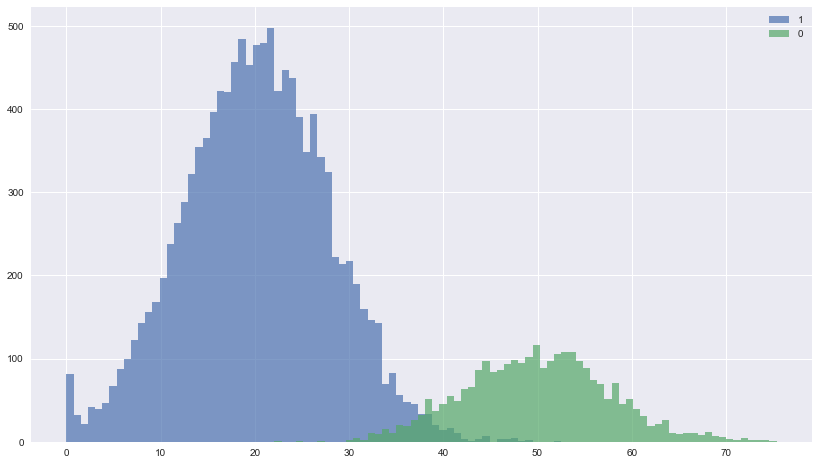

In [124]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(features.min(), features.max(), 100)
_ = plt.hist(features[np.logical_and(y_train == 0, train_mask)].reshape(-1), bins=bins, label='1', normed=False, alpha=.7)
_ = plt.hist(features[np.logical_and(y_train == 1, train_mask)].reshape(-1), bins=bins, label='0', normed=False, alpha=.7)
_ = plt.legend()

In [125]:
train_mask.sum(), test_mask.sum(), y_train.sum(), y_test.sum()

(737, 316, 133, 57)

## Write to HDF5 container

In [126]:
network_np = nx.to_numpy_matrix(network)
node_names = np.arange(num_nodes)
node_names = np.vstack([node_names, node_names]).transpose(1, 0) # just stack node numbers
node_names

array([[   0,    0],
       [   1,    1],
       [   2,    2],
       ...,
       [1050, 1050],
       [1051, 1051],
       [1052, 1052]])

In [127]:
y_train = y_train.reshape(num_nodes, 1)
y_test = y_test.reshape(num_nodes, 1)

network_np = nx.to_numpy_matrix(network)
node_names = np.arange(num_nodes)
node_names = np.vstack([node_names, node_names]).transpose(1, 0) # just stack node numbers

f = h5py.File('../data/simulation/simulated_all_unbalanced.h5', 'w')
f.create_dataset('network', data=network_np, shape=network_np.shape)
f.create_dataset('features', data=features, shape=features.shape)
f.create_dataset('gene_names', data=node_names, shape=node_names.shape)

f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
f.close()

## Make sure that Data is Correct by Looking at PCA Projection

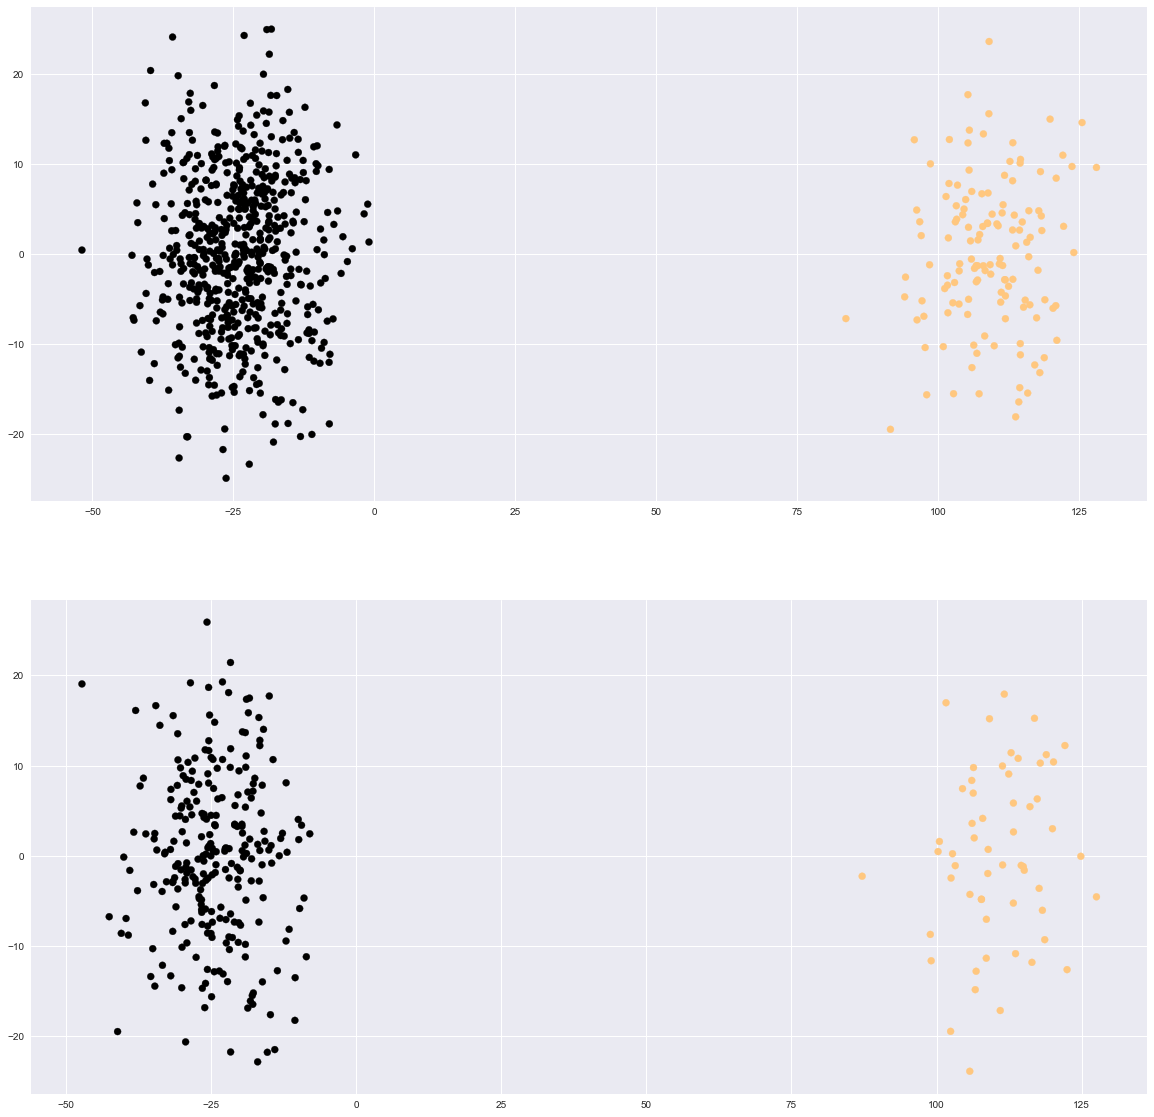

In [128]:
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
F_train = features[train_mask == 1]
emb = PCA(n_components=2).fit_transform(F_train)
plt.scatter(emb[:, 0], emb[:, 1], c=y_train[train_mask == 1], cmap=plt.cm.copper)

plt.subplot(2, 1, 2)
F_test = features[test_mask == 1]
emb = PCA(n_components=2).fit_transform(F_test)
plt.scatter(emb[:, 0], emb[:, 1], c=y_test[test_mask == 1], cmap=plt.cm.copper)

In [138]:
df = pd.DataFrame(features)
df[y == 1].mean().mean(), df[y == 1].var().mean()
df[y == 0].mean().mean(), df[y == 0].var().mean()
df['degree'] = network_np.sum(axis=1)

(4.831578947368421, 4.208574739281576)

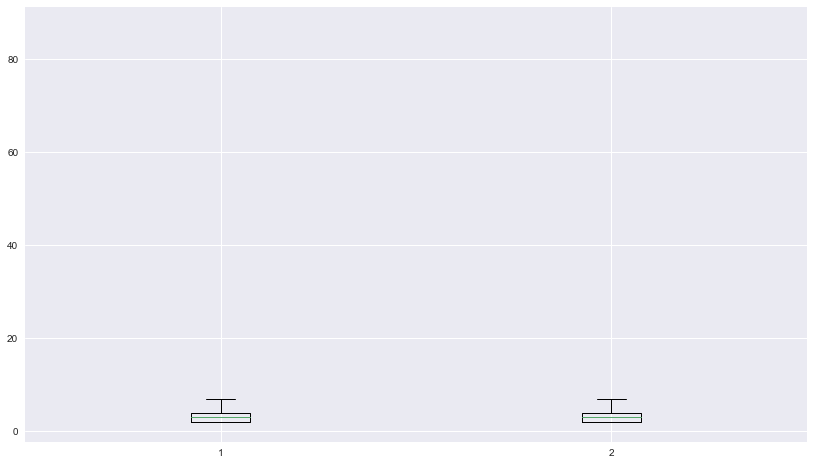

In [151]:
fig = plt.figure(figsize=(14, 8))
_ = plt.boxplot([df[df.index.isin(all_clique_nodes)].degree, df[~df.index.isin(all_clique_nodes)].degree])
df[y == 1].degree.mean(), df[y == 0].degree.mean()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,degree
0,48.077330,43.809005,45.729554,51.657299,49.995412,51.331359,50.126915,51.828815,48.366124,52.238008,...,36.523517,49.462446,35.422017,46.475028,58.136728,44.366694,57.642919,46.227875,50.966785,49.0
1,42.518577,36.848130,51.953549,53.031363,41.220438,48.416286,57.698723,38.986853,54.779845,43.413565,...,46.957825,42.468161,58.524485,62.559061,49.973090,38.357795,65.441520,39.064379,56.087061,73.0
2,51.893269,46.805057,51.436155,50.518536,53.360673,44.263191,46.899487,74.583871,51.920282,43.165556,...,50.657239,52.920478,38.441737,48.351701,50.097902,35.973462,45.636197,49.535799,61.598192,64.0
3,41.689768,54.801392,69.313422,59.739144,40.575814,55.498512,63.389493,48.358738,55.552010,43.822513,...,34.207475,37.969630,46.548237,47.038997,40.772955,48.604315,53.833843,49.364200,57.896881,5.0
4,34.972093,57.938769,50.433206,43.598766,47.795382,52.796888,44.868001,51.436830,51.562552,43.762639,...,48.947582,53.880419,42.864151,49.467522,54.340215,44.888874,37.368011,55.540218,44.766234,25.0
6,53.307962,45.801288,45.379977,51.016460,36.375484,47.780304,36.401942,40.610709,55.462633,51.868008,...,56.070996,48.531374,54.136058,60.224085,58.089143,37.300779,59.523207,53.291473,68.640073,9.0
7,47.243915,38.730057,48.623247,63.858703,48.533160,32.081851,64.449021,40.661508,38.861213,51.940509,...,48.475402,43.440498,53.778737,53.025670,51.127260,63.019271,46.613022,59.990931,56.894599,18.0
10,55.169563,41.015548,64.710069,43.529148,55.352062,58.740588,32.740169,51.211648,55.035353,62.303856,...,40.007488,44.982079,49.034468,30.899731,56.948838,48.750209,57.664323,32.125502,43.483172,4.0
11,40.481169,51.550306,44.954497,51.885855,49.730515,49.458946,59.503299,61.978977,43.727339,59.335314,...,69.379260,54.927705,56.793245,45.696137,55.732181,38.838414,41.344340,55.739803,45.797254,9.0
15,60.815551,46.751671,38.112280,47.046554,54.507244,49.155984,53.528725,48.833249,63.099541,50.807893,...,55.416251,54.787643,54.945573,46.319953,48.205424,41.977304,62.097124,41.724389,54.137520,6.0
